In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)
print("Running on:", device)

Running on: cpu


### Generating Wind Samples

We generate wind samples from an OU process. We want good variation in wind samples, so let's go with little mean-reversion.

In [118]:
# hyperparameters and wind generator function
n = 20
T = 50
L_x = 20
theta = 0.1
mu = 0
wind_sigma = 2
tau = torch.tensor(0.1, device = device)

def wind_process(T, theta, mu, wind_sigma, n, tau):
    winds = torch.zeros(n, T + 1, device = device)
    winds[:, 0] = 2 * torch.rand(n , device = device) - 1 # generates initial winds on a U[-1, 1] distribution
    for step in range(1, T + 1):
        dW = torch.randn(n , device = device)
        winds[:, step] = (mu - winds[:, step - 1]) * theta * tau + wind_sigma * torch.sqrt(tau) * dW
    return winds

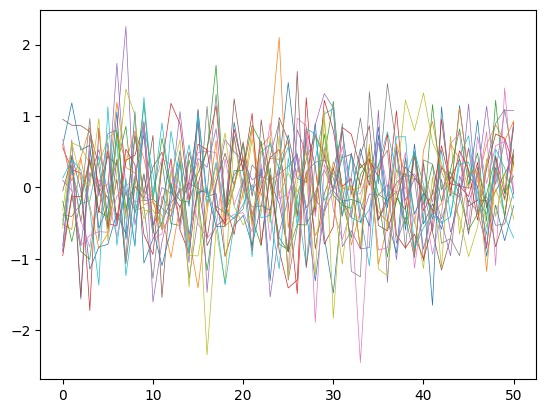

In [123]:
# test the generator and visualise

winds_tester = wind_process(T, theta, mu, wind_sigma, n, tau)
plt.plot(winds_tester.T, linewidth = 0.5)
plt.show()

### Define Neural Network Architecture

Single-hidden layer neural network, scaled by width for mean-field limit.

In [108]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, width, output_dim):
        super(NeuralNet, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, width)
        self.hidden_layer.bias.data.zero_()
        self.hidden_layer.bias.requires_grad = False
        self.sigmoid = nn.ReLU()
        self.output_layer = nn.Linear(width, output_dim)
        self.output_layer.bias.data.zero_()
        self.output_layer.bias.requires_grad = False
        self.width = width

    def forward(self, x):
        hidden_activations = self.sigmoid(self.hidden_layer(x))
        unscaled = self.output_layer(hidden_activations)
        return unscaled / self.width

### Loss Functions, Trajectory Realisation, and Uncontrolled Visualisation

We start without any regularisation.

In [124]:
# cost functions
A = 2 # controls how soft/hard the obstacle cost is
M = 100 # controls how high the cost is
def running_cost(x, y, A, M):
    return( 1 - 1/(1 + torch.exp(A * (1 - x**2 - y**2)))) * M

def terminal_cost(x, y, L_x):
    return torch.norm(x - L_x, dim = 1, keepdim = True)**2 + torch.norm(y, dim = 1, keepdim = True)**2

Before any training, we must produce our reference-controlled paths.

In [126]:
ref_ctrl = torch.zeros(n, 1, device = device)
initial_points = torch.zeros(n, 2, device = device) - torch.tensor([20, 0], device = device)
training_winds = wind_process(T, theta, mu, wind_sigma, n, tau)
def gen_ref_path(reference_control, p0, winds, vs, T):
    ref_path = torch.zeros(n, T+1, 2, device = device) # use a 3D tensor to store path information
    ref_path[:, 0, :] = p0 
    for t in range(T): 
        heading = torch.cat([torch.cos(reference_control), torch.sin(reference_control)], dim = 1)
        wind_vec = torch.cat([torch.zeros(n, device = device).view(n, 1), winds[:, t+1].view(n, 1)], dim = 1)
        ref_path[:, t+1, :] = ref_path[:, t] + vs * heading + wind_vec 
    return ref_path

In [127]:
tester = gen_ref_path(ref_ctrl, initial_points, training_winds, 0.8, T)

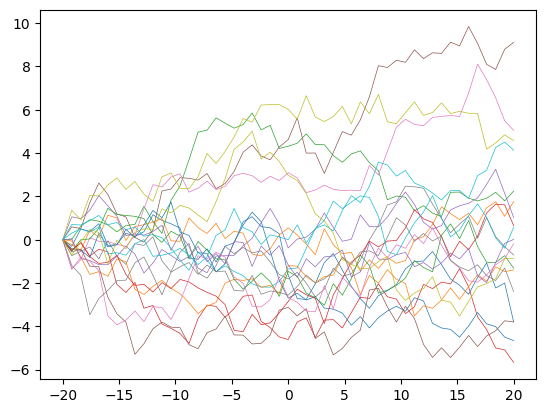

In [128]:
for pth in range(tester.shape[0]):
    plt.plot(tester[pth, :, 0], tester[pth, :, 1], linewidth = 0.5)

Our training procedure is as follows:
1. Parallelising over all steps in the backwards induction and training simultaneously. 
2. Run the forward pass from time t to T via the chosen models.
3. Compute the losses in a vectorised manner on the realised trajectories (more efficient than interchanging 2 and 3 at each step)
4. Backpropagate over model t.

We will begin with the unregularised version, and will start without parallelising over all t.

In [189]:
# initialise models, optimisers and learning rates
input_dim, width, output_dim = 4, 200, 1
start_rate, final_rate, num_epochs = 1, 0.00001, 1
models = [NeuralNet(input_dim, width, output_dim).to(device) for _ in range(T)]
optimizers = [optim.AdamW(model.parameters(), lr=start_rate) for model in models]
schedulers = [optim.lr_scheduler.CosineAnnealingLR(opt, T_max = num_epochs, eta_min = final_rate) for opt in optimizers]

In [190]:
vs = 0.8
ref_path = gen_ref_path(ref_ctrl, initial_points, training_winds, vs, T)
training_winds = wind_process(T, theta, mu, wind_sigma, n, tau)

# run without training first, just to check correctness of computation
for t in reversed(range(T)):
    print(f"Backwards Inductive Step t = {t}...")
    path_length = T - t
    for epoch in range(num_epochs):
        current_paths = torch.zeros(n, path_length + 1, 2, device = device) # + 1 since we store X_t^{ref}(Z) too
        current_paths[:, 0, :] = ref_path[:, t, :]
        # generate path from T
        for futs in range(path_length):
            angle = models[t + futs](torch.cat([current_paths[:, futs, :], training_winds[:, t + futs].view(n, 1), torch.ones(n, 1, device = device)], dim = 1))
            heading = torch.cat([torch.cos(angle), torch.sin(angle)], dim = 1)
            wind_vec = torch.cat([torch.zeros(n, device = device).view(n, 1), training_winds[:, t + futs + 1].view(n, 1)], dim = 1)
            current_paths[:, futs + 1, :] = current_paths[:, futs, :] + vs * heading + wind_vec

Backwards Inductive Step t = 49...
Backwards Inductive Step t = 48...
Backwards Inductive Step t = 47...
Backwards Inductive Step t = 46...
Backwards Inductive Step t = 45...
Backwards Inductive Step t = 44...
Backwards Inductive Step t = 43...
Backwards Inductive Step t = 42...
Backwards Inductive Step t = 41...
Backwards Inductive Step t = 40...
Backwards Inductive Step t = 39...
Backwards Inductive Step t = 38...
Backwards Inductive Step t = 37...
Backwards Inductive Step t = 36...
Backwards Inductive Step t = 35...
Backwards Inductive Step t = 34...
Backwards Inductive Step t = 33...
Backwards Inductive Step t = 32...
Backwards Inductive Step t = 31...
Backwards Inductive Step t = 30...
Backwards Inductive Step t = 29...
Backwards Inductive Step t = 28...
Backwards Inductive Step t = 27...
Backwards Inductive Step t = 26...
Backwards Inductive Step t = 25...
Backwards Inductive Step t = 24...
Backwards Inductive Step t = 23...
Backwards Inductive Step t = 22...
Backwards Inductive 

Visualising the obstacle cost over the different sample paths below. Use this to tinker with our choices for A and M. 

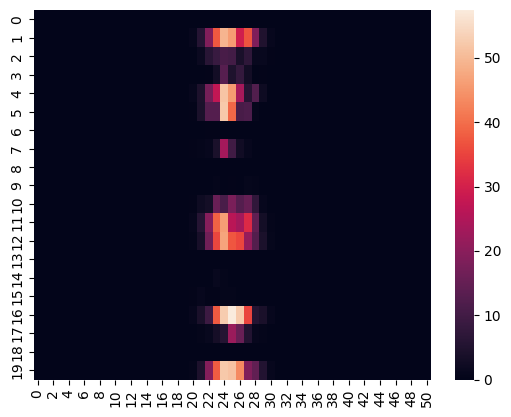

In [191]:
costs = running_cost(current_paths[:, :, 0], current_paths[:, :, 1], 0.3, 100)
import seaborn as sns
sns.heatmap(costs.detach())
plt.show()

In [ ]:
# now let's train
models = [NeuralNet(input_dim, width, output_dim).to(device) for _ in range(T)]
optimizers = [optim.AdamW(model.parameters(), lr=start_rate) for model in models]
schedulers = [optim.lr_scheduler.CosineAnnealingLR(opt, T_max = num_epochs, eta_min = final_rate) for opt in optimizers]
input_dim, width, output_dim = 4, 200, 1
start_rate, final_rate, num_epochs = 10, 0.01, 1000
vs = 0.8
ref_path = gen_ref_path(ref_ctrl, initial_points, training_winds, vs, T)
training_winds = wind_process(T, theta, mu, wind_sigma, n, tau)
# zeros and ones vectors so we don't keep having to remake it
zeros_vec, ones_vec = torch.zeros(n, 1, device = device), torch.ones(n, 1, device = device)
# run without training first, just to check correctness of computation
for t in reversed(range(T)):
    print(f"Backwards Inductive Step t = {t}...")
    path_length = T - t
    for epoch in range(num_epochs):
        current_paths = [ref_path[:, t, :]]
        # generate path from T
        for futs in range(path_length):
            angle = models[t + futs](torch.cat([current_paths[-1], training_winds[:, t + futs].view(n, 1), ones_vec], dim = 1))
            heading = torch.cat([torch.cos(angle), torch.sin(angle)], dim = 1)
            wind_vec = torch.cat([zeros_vec, training_winds[:, t + futs + 1].view(n, 1)], dim = 1)
            new_p = current_paths[-1] + vs * heading + wind_vec
            current_paths.append(new_p)
        # stack current_paths into a 3D tensor
        current_paths = torch.stack(current_paths, dim = 1)
        # compute losses
        # for running cost, exclude initial point (uncontrolled)
        running_c = running_cost(current_paths[:, 1:, 0], current_paths[:, 1:, 1], 2, 100)
        running_c = torch.sum(running_c, dim = 1)
        terminal_c = terminal_cost(current_paths[:, -1, 0].view(n, 1), current_paths[:, -1, 1].view(n ,1), L_x)
        final_c = torch.mean(running_c + terminal_c)
        # backprop and update
        final_c.backward()
        optimizers[t].step()
        optimizers[t].zero_grad()
        schedulers[t].step()

        if epoch % 100 == 0:
            with torch.no_grad():
                print(f" Epoch: {epoch}, Obstacle Cost: {running_c.mean().item():.6f}, Terminal Cost: {terminal_c.mean().item():.6f}")
    # freeze model after training
    for param in models[t].parameters():
        param.requires_grad = False


Backwards Inductive Step t = 49...
 Epoch: 0, Obstacle Cost: 0.000000, Terminal Cost: 15.061401
 Epoch: 100, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 200, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 300, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 400, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 500, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 600, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 700, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 800, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
 Epoch: 900, Obstacle Cost: 0.000000, Terminal Cost: 15.039998
Backwards Inductive Step t = 48...
 Epoch: 0, Obstacle Cost: 0.000000, Terminal Cost: 17.561085
 Epoch: 100, Obstacle Cost: 0.000000, Terminal Cost: 17.542919
 Epoch: 200, Obstacle Cost: 0.000000, Terminal Cost: 17.542919
 Epoch: 300, Obstacle Cost: 0.000000, Terminal Cost: 17.542919
 Epoch: 400, Obstacle Cost: 0.000000, Terminal Cost:

KeyboardInterrupt: 

tensor([[20.0000, -1.8078],
        [20.0000, -4.5541],
        [20.0000,  0.5291],
        [20.0000, -5.4277],
        [20.0000,  2.3446],
        [20.0000, -0.3110],
        [20.0000,  2.0978],
        [20.0000,  3.1794],
        [20.0000, -3.2207],
        [20.0000, -3.0614],
        [20.0000, -3.8666],
        [20.0000, -5.3743],
        [20.0000, -0.2158],
        [20.0000, -5.3254],
        [20.0000, -1.4453],
        [20.0000,  8.8737],
        [20.0000, -0.2913],
        [20.0000, -1.5475],
        [20.0000, -2.2657],
        [20.0000, -3.5199]], grad_fn=<SliceBackward0>)